In [5]:
import os
import torch
import matplotlib.pyplot as plt

from pytorch3d.utils import ico_sphere
import numpy as np
# from tqdm.notebook import tqdm

#from tqdm import tqdm
from tqdm.autonotebook import tqdm as tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj, load_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

from torchvision.io import read_image

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    PerspectiveCameras,
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)
from PIL import Image

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

from pytorch3d.io import load_obj, load_ply
from pytorch3d.renderer import RasterizationSettings, PointLights, MeshRenderer, MeshRasterizer, TexturesVertex, SoftPhongShader, SfMPerspectiveCameras, PerspectiveCameras, BlendParams, FoVPerspectiveCameras, FoVOrthographicCameras
from pytorch3d.structures import Meshes

from pytorch3d.structures import Meshes, join_meshes_as_batch, join_meshes_as_scene, Pointclouds
# from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

from pytorch3d.renderer.mesh.textures import TexturesUV

from pytorch3d.io import IO
import glob


In [9]:
path = './data/seth-SHOW1/all_transl_SHOW_seth.npy'
arr = np.load(path)
print(arr.shape)
files = glob.glob('./data/seth-SHOW1/background/*.png')
print(len(files))

(10560, 3)
10562


In [20]:
path = './data/seth-SHOW1/seth.npz'
arr = np.load(path, allow_pickle=True)
print(arr['arr_0'])

{'fl': array([[15.625]]), 'pp': array([0.09375, 0.     ]), 'R': array([[[-1,  0,  0],
        [ 0,  1,  0],
        [ 0,  0, -1]]])}


In [2]:
texture_image = read_image('/data/richa/code/uv_smpl/smplx_uv.png').permute(1,2,0).unsqueeze(0).float()
a = texture_image[0][:,:,:3]/255
a.shape, a.min(), a.max()

(torch.Size([1024, 1024, 3]), tensor(0.), tensor(0.2000))

In [83]:
texture_image = read_image('/data/richa/code/uv_smpl/cow_texture.png').permute(1,2,0).unsqueeze(0).float()
texture_image /= 255

libpng warning: iCCP: known incorrect sRGB profile


In [29]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")


# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "/data/richa/code/uv_smpl/smplx_uv.obj")

verts, faces, aux = load_obj(obj_filename)
verts_uvs = aux.verts_uvs[None, ...].to(device)  # (1, V, 2)
faces_uvs = faces.textures_idx[None, ...].to(device)  # (1, F, 3)
texture_image = torch.zeros((1,1024, 1024, 3)).to(device)


mesh = load_objs_as_meshes([obj_filename], device=device)
tex = TexturesUV(verts_uvs=verts_uvs, faces_uvs=faces_uvs, maps=texture_image)
mesh.texture = tex

In [4]:
save_obj("final_model.obj", verts=verts, faces=faces.verts_idx, verts_uvs=verts_uvs[0], faces_uvs=faces_uvs[0], texture_map=texture_image[0][:,:,:3])

In [32]:
aux.verts_uvs.shape, verts.shape, faces.textures_idx.shape, faces.verts_idx.shape, aux.texture_images

(torch.Size([11313, 2]),
 torch.Size([10475, 3]),
 torch.Size([20908, 3]),
 torch.Size([20908, 3]),
 None)

In [5]:
n_frame = 1
R = np.array([[[-1,0,0],[0,1,0],[0,0,-1]]]).repeat(n_frame, 0)
T = np.array([[-0.19163294, -0.7803175, 5.7486043 ]])
fl = np.array([[19.53125]]).repeat(n_frame, 0)
pp = np.array([[0.75, -0.37109375]]).repeat(n_frame, 0)

In [19]:

obj_filename = os.path.join(DATA_DIR, "/data/richa/code/uv_smpl/smplx_uv.obj")

verts, faces, aux = load_obj(obj_filename)
texture_image = torch.zeros((1,1024, 1024, 3))


mesh = load_objs_as_meshes(['/data/richa/code/uv_smpl/full_body_rot180/00000.obj'], device=device)
tex = TexturesUV(verts_uvs=verts_uvs, faces_uvs=faces_uvs, maps=texture_image).to(device)
mesh.textures = tex

In [20]:
mesh.textures

In [21]:
raster_settings = RasterizationSettings(
        image_size=256,
        faces_per_pixel=1,
        cull_backfaces=True,
        perspective_correct=True
)
lights = PointLights(
            device=device,
            location=((0.0, 0.0, 5.0),),
            ambient_color=((0.5, 0.5, 0.5),),
            diffuse_color=((0.5, 0.5, 0.5),)
        )

camera = PerspectiveCameras(focal_length=fl, 
                             principal_point=pp, 
                             R=R, 
                             T=T, 
                             image_size=256, 
                             device=device)

blend = BlendParams(background_color=(1.0, 1.0, 1.0))
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights,
        blend_params=blend,
    )
)

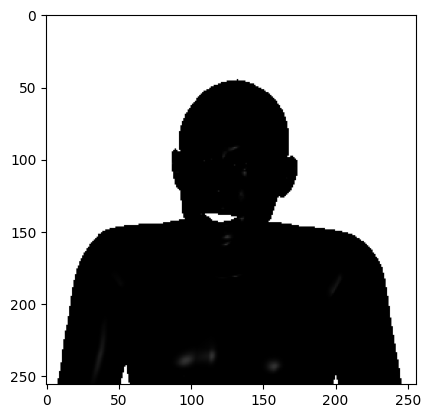

In [22]:
target_images = renderer(mesh, cameras=camera, lights=lights)
num_views = 1
target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
target_cameras = [camera]
from matplotlib import pyplot as plt
plt.imshow(target_rgb[0].cpu().numpy())
plt.show()

In [23]:
img = Image.open('/data/richa/code/uv_smpl/johnoliver_shoulders_final/matted/00000.png')
img = img.resize((256, 256))
img = torch.from_numpy(np.array(img)/255.)
target_rgb = [img[:,:,:3].to('cuda')]

In [24]:
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=SoftSilhouetteShader()
)

def visualize_prediction(predicted_mesh, renderer=renderer_silhouette, 
                         target_image=target_rgb[0], title='', 
                         silhouette=False):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")

# Plot losses as a function of optimization iteration
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

In [25]:
src_mesh = mesh.clone()

In [34]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 1
# Number of optimization steps
Niter = 100000
# Plot period for the losses
plot_period = 1000

%matplotlib inline

# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)
    
    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)
    
    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

# Optimize using rendered RGB image loss, rendered silhouette image loss, mesh 
# edge loss, mesh normal consistency, and mesh laplacian smoothing
losses = {"rgb": {"weight": 1.0, "values": []},
          "silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in 
# src_mesh
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# We will also learn per vertex colors for our sphere mesh that define texture 
# of the mesh

texture_image = torch.ones((1,256, 256, 3), device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([texture_image], lr=1.0, momentum=0.9)

In [32]:
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=SoftPhongShader(device=device, 
        cameras=camera,
        lights=lights)
)

In [35]:
loop = tqdm(range(Niter))

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # Add per vertex colors to texture the mesh
    new_src_mesh.textures = TexturesUV(verts_uvs=verts_uvs, faces_uvs=faces_uvs, maps=texture_image).to(device)
    
    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    # update_mesh_shape_prior_losses(new_src_mesh, loss)
    
    # Randomly select two views to optimize over in this iteration.  Compared
    # to using just one view, this helps resolve ambiguities between updating
    # mesh shape vs. updating mesh texture
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_textured(new_src_mesh, cameras=target_cameras[j], lights=lights)
        predicted_rgb = images_predicted[..., :3]
        loss_rgb = ((predicted_rgb - target_rgb[j]) ** 2).mean()
        loss["rgb"] += loss_rgb / num_views_per_iteration
    
    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))
    
    # Print the losses
    # loop.set_description("total_loss = %.6f" % sum_loss)
    
    # Plot mesh
    if i % plot_period == 0:
        visualize_prediction(new_src_mesh, renderer=renderer_textured, title="iter: %d" % i, silhouette=False)
        
        print(sum_loss, texture_image.max(), texture_image.min())
        a = texture_image.detach().cpu().numpy()[0]#.clip(0,1)
        a = Image.fromarray((255*(a.clip(0,1))).astype(np.uint8))
        a.save(f'a_{i}.png')
        if i % 10000 == 0:
            np.save(f'a_{i}.npy', a)
            
        
        
    # Optimization step
    sum_loss.backward()
    optimizer.step()

  0%|          | 5/100000 [00:00<1:12:07, 23.11it/s]

tensor(0.7078, device='cuda:0', grad_fn=<AddBackward0>) tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) tensor(1., device='cuda:0', grad_fn=<MinBackward1>)


  1%|          | 1004/100000 [00:38<1:07:20, 24.50it/s]

tensor(0.5779, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0068, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.2754, device='cuda:0', grad_fn=<MinBackward1>)


  2%|▏         | 1547/100000 [00:59<1:03:05, 26.01it/s]

In [68]:
texture_image.max(), texture_image.min()

(tensor(1.0057, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0.3443, device='cuda:0', grad_fn=<MinBackward1>))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


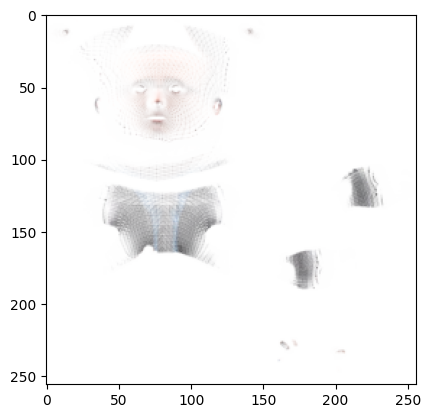

In [69]:
plt.imshow(texture_image.detach().cpu().numpy()[0])

In [79]:
from PIL import Image

a = texture_image.detach().cpu().numpy()[0].clip(0,1)



a = Image.fromarray((255*a).astype(np.uint8))
a.save('a.png')